# Perfíl de Pozo desde archivo LAS

**Created by:** Rubens Merlino

**Based on works of:** Andy McDonald  


## Loading and Checking Data
The first step is to import the required libraries: pandas, matplotlib and LASIO.  
lasio is a library that has been developed to handle and work with LAS files. More info on the library can be found at: https://lasio.readthedocs.io/en/latest/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import stratilib as sl

%matplotlib inline 
#%matplotlib qt 

## Definición de variables globales (defaults.py)

In [199]:
#Diccionario para granulometría
DICT_GRAN = {'cl':0.55,
              's':0.6,
              'vf':0.65,
              'f':0.7,
              'm':0.75,
              'c':0.8,
              'vc':0.85,
              'g':0.9}


#Diccionario para litologías
DICT_LITO = {'C':100,
            'M':200,
            'B':300,
            'S':400,
            'Sf':400,
            'Sm':450,
            'Sc':475,
            'Sg':490,
            'G':500,
            'D':600}

#Definición de tramas y colores para las litologías
LITHOLOGYS = {400: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
              450: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#e8e800'},
              475: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#cfcf02'},
              490: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#b3b302'},
              100: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
              65000: {'lith':'Shale', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
              74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
              86000: {'lith':'Limestone', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
              70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
              65030: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
              200: {'lith':'Mudstone', 'lith_num':9, 'hatch':'', 'color':'#9c793e'},
              600: {'lith':'Diabase', 'lith_num':10, 'hatch':'-|', 'color':'#144513'},
              300: {'lith':'Basalt', 'lith_num':11, 'hatch':'', 'color':'#144513'},
              500: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'},
              8800: {'lith':'Gypsum', 'lith_num':13, 'hatch':'\\\\', 'color':'#ef138a'},
              8440: {'lith':'Conglomerade', 'lith_num':14, 'hatch':'O', 'color':'#b3b302'}}


## Funciones (funcion.py)


In [204]:
def read_lito(name, **kwargs):
    sand_colors = 'False'
    dfLito = pd.read_excel(name)
    
    tope = 0
    base = 0
    por_tope = dfLito['Espesor'].isnull().sum() ==len(dfLito)
    
    for i in range(len(dfLito)):
        if por_tope:            
            base= dfLito.loc[i+1,'Tope'] if i < len(dfLito)-1 else dfLito.loc[i,'Tope'] + 99
            dfLito.loc[i,'Base'] = base
            dfLito.loc[i,'Espesor'] = base-dfLito.loc[i,'Tope']
        else:            
            base += dfLito.loc[i,'Espesor']
            dfLito.loc[i,'Tope'] = tope  
            dfLito.loc[i,'Base'] = base
            tope += dfLito.loc[i,'Espesor']

    for key, value in kwargs.items():
        if (key == 'sand_colors'):
            if (value == 'True'):
                dfLito.loc[dfLito['Litología']=='S','Litología'] = dfLito['Litología'] + dfLito['Granulometría']
                dfLito['Litología'] = dfLito['Litología'].map(DICT_LITO)
            else:
                dfLito['Litología'] = dfLito['Litología'].map(DICT_LITO)
        
    dfLito['Gran'] = dfLito['Granulometría'].map(DICT_GRAN)
    dfLito['Gran'].fillna(1, inplace=True)
    dfLito['Descripción'].fillna('', inplace=True)
               
    return dfLito

In [212]:
dfLito = read_lito('Litotope.xlsx')
dfLito

,Pozo,Fm,Tope,Base,Espesor,Litología,Granulometría,Estructuras,Fósiles,Descripción,Gran
0,NaN,NaN,0,3.0,3.0,C,NaN,NaN,NaN,,1.0
1,NaN,NaN,3,15.0,12.0,M,NaN,NaN,NaN,,1.0
2,NaN,NaN,15,18.0,3.0,M,NaN,NaN,NaN,alto angulo,1.0
3,NaN,NaN,18,21.0,3.0,B,NaN,NaN,NaN,,1.0
4,NaN,NaN,21,36.0,15.0,B,NaN,NaN,NaN,,1.0
...,...,...,...,...,...,...,...,...,...,...,...
182,NaN,NaN,2030,2032.0,2.0,D,NaN,NaN,NaN,,1.0
183,NaN,NaN,2032,2094.0,62.0,D,NaN,NaN,NaN,,1.0
184,NaN,NaN,2094,2128.0,34.0,D,NaN,NaN,NaN,,1.0
185,NaN,NaN,2128,2130.0,2.0,D,NaN,NaN,NaN,,1.0


In [206]:
#Función para el ploteo de perfíl litológico
'''
Tenemos que sumar:
    -Eras geológicas
    -Períodos
    -Escaldo de fósiles
    -Tipo de contacto
    -Dos litolgías
    -suavizar curva
    -
'''

#Parámetros:
    #tope, base,
    
def sub_plot_lito(dfLito, sub_plots, tope, base, **kwargs):
    #Variables **kwargs por defecto:
    show_fm = False
    show_gr = False
    show_fossils = False
    show_era = False
    show_des = False
    color_fill = False
    fm_rot = 90
    fm_size = 20
    x_plot = 0
    escala = (base - tope)/2500
    axL = plt.subplot2grid((1,sub_plots), (0,0), rowspan=1, colspan = 1)        
        
    dfLito_aux = dfLito.copy()
    dfLito_aux['Base'] = dfLito['Tope']
    dfLito = pd.concat([dfLito_aux,dfLito])
    dfLito.sort_values(by=['Tope', 'Base'], inplace =True)
    
    Fms = dfLito[['Fm', 'Tope']].groupby(['Fm']).first()
    Fms['Base']= dfLito[['Fm', 'Base']].groupby(['Fm']).last()
    Fms.reset_index(inplace=True)
    
    
    for key, value in kwargs.items():
        if (key == 'show_fm') & (value == 'True'):
            show_fm = True
            Fms = dfLito[['Fm', 'Tope']].groupby(['Fm']).first()
            Fms['Base']= dfLito[['Fm', 'Base']].groupby(['Fm']).last()
            Fms.reset_index(inplace=True)
            x_plot +=0.5
        if (key == 'show_gr') & (value == 'True'):
            show_gr = True
        if (key == 'color_fill') & (value == 'True'):
            color_fill = True
        if (key == 'show_fossils') & (value == 'True'):
            show_fossils = True
        if (key == 'fm_rot'):
            fm_rot = value
        if (key == 'fm_size'):
            fm_size = value
            
       
    # Lithology track
    axL.plot(dfLito["Litología"], dfLito['Base'], color = "black", linewidth = 0.5)
    axL.set_xlabel("Litología")
    axL.set_xlim(0, x_plot+1)
    axL.xaxis.label.set_color("black")
    axL.tick_params(axis='x', colors="black")
    axL.spines["top"].set_edgecolor("black")
    axL.hlines(y=tope, xmin=0, xmax=x_plot+1, colors='black', ls='-', lw=1, label='vline_single - full height',alpha = 1, zorder = 5)
    
    #Ploteo de granulometrías
    if show_gr:
        axL.vlines(x=x_plot, ymin=tope, ymax=base, colors='black', ls='-', lw=1, label='vline_single - full height',alpha = 1, zorder = 5)
        axL.vlines(x=x_plot+0.65, ymin=tope, ymax=base, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3, zorder = 5)
        axL.vlines(x=x_plot+0.7, ymin=tope, ymax=base, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3,zorder = 5)
        axL.vlines(x=x_plot+0.75, ymin=tope, ymax=base, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3,zorder = 5)
        axL.vlines(x=x_plot+0.8, ymin=tope, ymax=base, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3,zorder = 5)
        axL.vlines(x=x_plot+0.85, ymin=tope, ymax=base, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3,zorder = 5)
        axL.vlines(x=x_plot+0.9, ymin=tope, ymax=base, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3,zorder = 5)
        axL.plot(x_plot+dfLito['Gran'],dfLito['Base'], color="black", zorder =10, lw=0.8)
    
    pos1 =1100
    pos2 =1300
    if show_fossils:
        axL.imshow(rip, extent=[x_plot+0.15,x_plot+0.45,pos1,(pos1-(pos1/10)*(2*escala))], aspect='auto', zorder=20)
        axL.imshow(rip, extent=[x_plot+0.35,x_plot+0.65,pos1,(pos1-(pos1/10)*(2*escala))], aspect='auto', zorder=20)
        axL.imshow(im, extent=[x_plot+0.2,x_plot+0.45,pos2,(pos2-(pos2/10)*escala)], aspect='auto', zorder=20)

    
    #Ploteamos las Formaciones
    if show_fm:
        x = np.arange(0,1,0.001)   # start,stop,step
        y = np.sin(50*x)
        bbox_props = dict(boxstyle="Round, pad=0.8", fc="w", ec="0.5", alpha=0.0)
        for i in range(len(Fms)):
            if (Fms.iloc[i,2] > tope) & (Fms.iloc[i,1] < base):
                x_tope = Fms.iloc[i,1] if Fms.iloc[i,1] > tope else tope
                x_base = Fms.iloc[i,2] if Fms.iloc[i,2] < base else base                
                axL.text(0.25, (x_tope+x_base)/2, Fms.iloc[i,0], 
                    ha="center", va="center", size=fm_size,
                    bbox=bbox_props, zorder=1,rotation=fm_rot)
                #axL.hlines(y=Fms.iloc[i,2], xmin=0, xmax=2, colors='black', ls='-', lw=1, label='vline_single - full height',zorder = 5)
                axL.plot(x,Fms.iloc[i,2]+escala*8*y, color="black", zorder =10, lw=1)

                
    #Ploteamos Eras
    if show_era:
        x = np.arange(0,1,0.001)   # start,stop,step
        y = np.sin(50*x)
        bbox_props = dict(boxstyle="Round, pad=0.8", fc="w", ec="0.5", alpha=0.0)
        for i in range(len(Fms)):
            if (Fms.iloc[i,2] > tope) & (Fms.iloc[i,1] < base):
                x_tope = Fms.iloc[i,1] if Fms.iloc[i,1] > tope else tope
                x_base = Fms.iloc[i,2] if Fms.iloc[i,2] < base else base                
                axL.text(0.25, (x_tope+x_base)/2, Fms.iloc[i,0], 
                    ha="center", va="center", size=fm_size,
                    bbox=bbox_props, zorder=1,rotation=fm_rot)
                #axL.hlines(y=Fms.iloc[i,2], xmin=0, xmax=2, colors='black', ls='-', lw=1, label='vline_single - full height',zorder = 5)
                axL.plot(x,Fms.iloc[i,2]+escala*8*y, color="black", zorder =10, lw=1)

                    
    #Relleno de las Formaciones
    for key in LITHOLOGYS.keys():
        color = LITHOLOGYS[key]['color'] if color_fill else '#FF000000'
        hatch = LITHOLOGYS[key]['hatch']
        axL.fill_betweenx(dfLito['Base'], x_plot, x_plot+(dfLito['Gran'] if show_gr else 1), interpolate = 'True'
                          , where=(dfLito['Litología']==key),
                         facecolor=color, hatch=hatch)
        
        
    return axL
    

In [207]:
def sub_plot_des(df_des, sub_plots, tope, base):
    axD = plt.subplot2grid((1,sub_plots), (0,sub_plots-1), rowspan=1, colspan = 1)        

    axD.set_xlim(0, 1)
    axD.hlines(y=tope, xmin=0, xmax=1, colors='black', ls='-', lw=1, label='vline_single - full height',alpha = 1, zorder = 5)
    axD.set_xlabel("Descripción")
    axD.xaxis.set_label_position("top")
    
    #Ploteamos las descripciones
    for i in range(len(df_des)):
        if (df_des.iloc[i,2] > tope) & (df_des.iloc[i,3] < base):
            axD.hlines(y=df_des.iloc[i,3], xmin=0, xmax=1, colors='black', ls='-', lw=1, label='vline_single - full height',alpha = 1, zorder = 5)
            bbox_props = dict(boxstyle="Round, pad=0.8", fc="w", ec="0.5", alpha=0.0)
            axD.text(0.01, df_des.iloc[i,3], df_des.iloc[i,9], 
                ha="left", va="bottom", size=10, multialignment='left',
                bbox=bbox_props, zorder=1,rotation=0)

    return axD

In [208]:
def plot_lito(dfLito, ancho, tope, base, **kwargs):
    
    sub_plots = 1
    
    for key, value in kwargs.items():
        if (key == 'show_des') & (value == 'True'):
            sub_plots += 1
            fig, axL = plt.subplots(figsize=(ancho*3,ancho*4))
            axD = plt.subplot2grid((1,sub_plots), (0,sub_plots-1), rowspan=1, colspan = 1)
            axD = sub_plot_des(dfLito, sub_plots, tope, base)
            axD.set_ylim(base, tope)
            axD.grid(which='major', color='lightgrey', linestyle='-')
            axD.xaxis.set_ticks_position("top")
            #axD.xaxis.set_label_position("top")
            axD.spines["top"].set_position(("axes", 1.02))
            plt.setp(axD.get_xticklabels(), visible = False)
            plt.setp(axD.get_yticklabels(), visible = False)
            axD.tick_params(axis='x', colors="black")
            axD.grid(False)
        elif (key == 'show_des') & (value == 'False'):
            fig, axL = plt.subplots(figsize=(ancho,ancho*4))
    
            
    
    axL = plt.subplot2grid((1,sub_plots), (0,0), rowspan=1, colspan = 1)
    axL = sub_plot_lito(dfLito, sub_plots, tope, base, **kwargs)

    axL.set_ylim(base, tope)
    axL.grid(which='major', color='lightgrey', linestyle='-')
    axL.xaxis.set_ticks_position("top")
    axL.xaxis.set_label_position("top")
    axL.spines["top"].set_position(("axes", 1.02))
    plt.setp(axL.get_xticklabels(), visible = False)
    axL.grid(False)

   
    plt.subplots_adjust(wspace=0)
        
    plt.show()

## uso


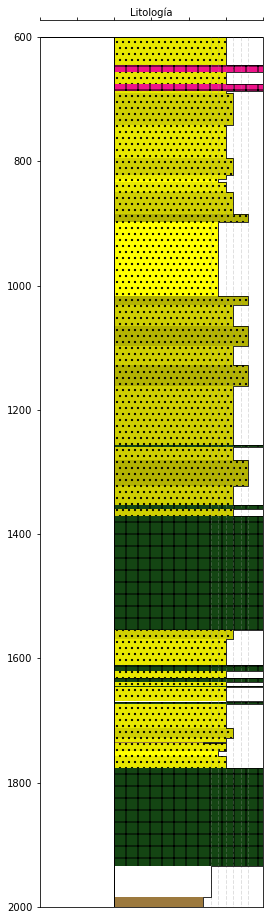

In [211]:
plot_lito(read_lito('Litotope.xlsx', sand_colors = 'True'), 4, 600, 2000, 
               show_fm='True', 
               show_gr='True', 
               show_fossils='False', 
               show_des = 'False',
               color_fill = 'True')

In [202]:
read_lito('Litotope.xlsx')

,Pozo,Fm,Tope,Base,Espesor,Litología,Granulometría,Estructuras,Fósiles,Descripción,Gran
0,NaN,NaN,0,3.0,3.0,100.0,NaN,NaN,NaN,,1.0
1,NaN,NaN,3,15.0,12.0,200.0,NaN,NaN,NaN,,1.0
2,NaN,NaN,15,18.0,3.0,200.0,NaN,NaN,NaN,alto angulo,1.0
3,NaN,NaN,18,21.0,3.0,300.0,NaN,NaN,NaN,,1.0
4,NaN,NaN,21,36.0,15.0,300.0,NaN,NaN,NaN,,1.0
...,...,...,...,...,...,...,...,...,...,...,...
182,NaN,NaN,2030,2032.0,2.0,600.0,NaN,NaN,NaN,,1.0
183,NaN,NaN,2032,2094.0,62.0,600.0,NaN,NaN,NaN,,1.0
184,NaN,NaN,2094,2128.0,34.0,600.0,NaN,NaN,NaN,,1.0
185,NaN,NaN,2128,2130.0,2.0,600.0,NaN,NaN,NaN,,1.0


In [55]:
dfLito

,Pozo,Fm,Tope,Base,Espesor,Litología,Granulometría,Estructuras,Fósiles,Descripción,Gran
0,NaN,NaN,0,0,3,100.0,NaN,NaN,NaN,NaN,1.0
0,NaN,NaN,0,3,3,100.0,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,3,3,12,200.0,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,3,15,12,200.0,NaN,NaN,NaN,NaN,1.0
2,NaN,NaN,15,15,3,200.0,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
184,NaN,NaN,2094,2128,34,600.0,NaN,NaN,NaN,NaN,1.0
185,NaN,NaN,2128,2128,2,600.0,NaN,NaN,NaN,NaN,1.0
185,NaN,NaN,2128,2130,2,600.0,NaN,NaN,NaN,NaN,1.0
186,NaN,NaN,2130,2130,0,600.0,NaN,NaN,NaN,NaN,1.0


In [ ]:
im = plt.imread('images/Amo.png')
rip =  plt.imread('images/ripple.png')

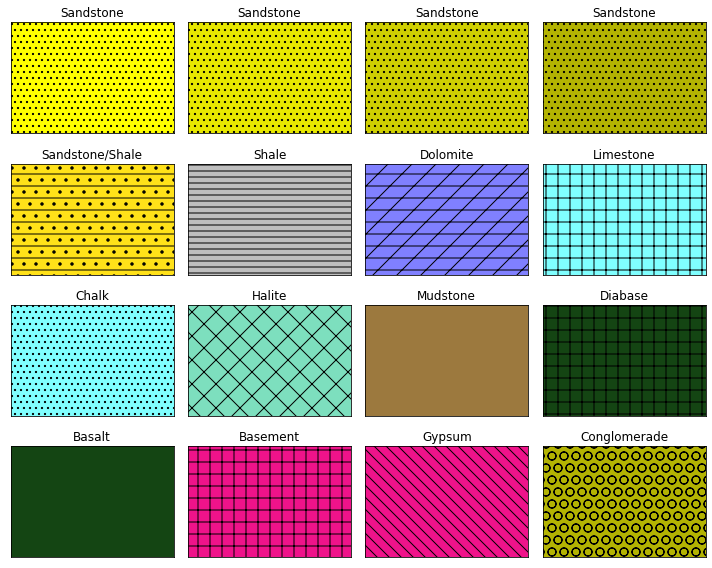

In [100]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=4, sharex=True, sharey=True,
                         figsize=(10,8), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, LITHOLOGYS.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=LITHOLOGYS[key]['color'], hatch=LITHOLOGYS[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(LITHOLOGYS[key]['lith']))

plt.tight_layout()

plt.show()


In [ ]:
plot_lito(read_lito('Lito.xlsx'), 4, 0, 300, 
               show_fm='True', 
               show_gr='True', 
               show_fossils='False', 
               color_fill = 'True')

In [ ]:
x = np.arange(0,5,0.001)   # start,stop,step
y = np.sin(50*x)

plt.plot(x,y)
plt.show()

In [ ]:
escala = (base - tope)/2500
escala

### Comenzamos predicciones

In [ ]:
df = pd.read_excel("FCIEN/Pozo N0_9_B_X1 - BELEN.xlsx")

In [ ]:
workingdf = df[["DEPT:2", "ILD", "ILM", "SFLU", "SP", "GR"]].copy()

In [ ]:
lithology_numbers = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

In [ ]:
simple_lithology_numbers = {30000: 1,
                 65030: 2,
                 65000: 3,
                 80000: 4,
                 74000: 5,
                 70000: 6,
                 70032: 7,
                 88000: 8,
                 86000: 9,
                 99000: 10,
                 90000: 11,
                 93000: 12}

In [ ]:
def create_plot(wellname, dataframe, curves_to_plot, depth_curve, log_curves=[], facies_curves=[]):
    # Count the number of tracks we need
    num_tracks = len(curves_to_plot) + 1
    
    facies_color = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D', 'red','black', 'blue']
    
            
    # Setup the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(num_tracks*2, 10))
    
    # Create a super title for the entire plot
    fig.suptitle(wellname, fontsize=20, y=1.05)
    
    # Loop through each curve in curves_to_plot and create a track with that data
    for i, curve in enumerate(curves_to_plot):
        if curve in facies_curves:
            cmap_facies = colors.ListedColormap(facies_color[0:dataframe[curve].max()], 'indexed')
            
            cluster=np.repeat(np.expand_dims(dataframe[curve].values,1), 100, 1)
            im=ax[i].imshow(cluster, interpolation='none', cmap=cmap_facies, aspect='auto',vmin=dataframe[curve].min(),vmax=dataframe[curve].max(), 
                            extent=[0,20, depth_curve.max(), depth_curve.min()])
            
#             for key in lithology_setup.keys():
#                 color = lithology_setup[key]['color']
#                 ax[i].fill_betweenx(depth_curve, 0, dataframe[curve].max(), 
#                                   where=(dataframe[curve]==key),
#                                   facecolor=color)
#                 
        else:
            ax[i].plot(dataframe[curve], depth_curve)

        
        # Setup a few plot cosmetics
        ax[i].set_title(curve, fontsize=14, fontweight='bold')
        ax[i].grid(which='major', color='lightgrey', linestyle='-')
        
        # We want to pass in the deepest depth first, so we are displaying the data 
        # from shallow to deep
        ax[i].set_ylim(depth_curve.max(), depth_curve.min())
#         ax[i].set_ylim(3500, 3000)

        # Only set the y-label for the first track. Hide it for the rest
        if i == 0:
            ax[i].set_ylabel('DEPTH (m)', fontsize=18, fontweight='bold')
        else:
            plt.setp(ax[i].get_yticklabels(), visible = False)
        
        # Check to see if we have any logarithmic scaled curves
        if curve in log_curves:
            ax[i].set_xscale('log')
            ax[i].grid(which='minor', color='lightgrey', linestyle='-')
        

    axL = plt.subplot2grid((1,7), (0,6), rowspan=1, colspan = 1, sharey = ax1)
    # Lithology track
    axL.plot(dfLito["Litología"], dfLito['Base'], color = "black", linewidth = 0.5)
    axL.set_xlabel("Litología")
    axL.set_xlim(0, 1)
    axL.xaxis.label.set_color("black")
    axL.tick_params(axis='x', colors="black")
    axL.spines["top"].set_edgecolor("black")
    # single vline with full ymin and ymax
    axL.vlines(x=0.65, ymin=0, ymax=4000, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3, zorder = 5)
    axL.vlines(x=0.7, ymin=0, ymax=4000, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3,zorder = 5)
    axL.vlines(x=0.75, ymin=0, ymax=4000, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3,zorder = 5)
    axL.vlines(x=0.8, ymin=0, ymax=4000, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3,zorder = 5)
    axL.vlines(x=0.85, ymin=0, ymax=4000, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3,zorder = 5)
    axL.vlines(x=0.9, ymin=0, ymax=4000, colors='#999999', ls='--', lw=1, label='vline_single - full height',alpha = 0.3,zorder = 5)

    axL.hlines(y=cambios, xmin=0, xmax=granos, colors='#999999', ls='-', lw=1, label='vline_single - full height',alpha = 0.5,zorder = 5)
    axL.plot(dfLito['Gran'],dfLito['Base'], color="black", zorder =10, lw=0.8)

    for key in lithologys.keys():
        color = lithologys[key]['color']
        hatch = lithologys[key]['hatch']
        axL.fill_betweenx(dfLito['Base'], 0, dfLito['Gran'], where=(dfLito['Litología']==key),
                         facecolor=color, hatch=hatch)  
    
    plt.tight_layout()
    plt.savefig("KNN.jpg")
    plt.show()
    
    return cmap_facies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [ ]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

In [ ]:
workingdf.dropna(inplace=True)

In [ ]:
optimise_k_means(workingdf[['ILD', 'ILM', 'SFLU', 'SP', 'GR']], 30)

In [ ]:
# Create the KMeans model with the selected number of clusters
kmeans = KMeans(n_clusters=5)

# Fit the model to our dataset
kmeans.fit(workingdf[['ILD', 'ILM', 'SFLU', 'SP', 'GR']])

# Assign the data back to the workingdf
workingdf['KMeans'] = kmeans.labels_

In [ ]:
# Create the gmm model with the selected number of clusters/components
gmm = GaussianMixture(n_components=5)

# Fit the model to our dataset
gmm.fit(workingdf[['ILD', 'ILM', 'SFLU', 'SP', 'GR']])

# Predict the labels
gmm_labels = gmm.predict(workingdf[['ILD', 'ILM', 'SFLU', 'SP', 'GR']])

# Assign the labels back to the workingdf
workingdf['GMM'] = gmm_labels

In [ ]:
# Setup the curves to plot
curves_to_plot = ['ILD', 'ILM', 'SFLU', 'SP', 'GR', 'KMeans','GMM']
logarithmic_curves = ['RDEP']
facies_curve=['KMeans','GMM']

# Create plot by passing in the relevant well index numberb
cmap_facies = create_plot('PEPO', 
            workingdf, 
            curves_to_plot, 
            workingdf['DEPT:2'], 
            logarithmic_curves, facies_curve)